In [1]:
# libraries
import zipfile, io
import urllib
import os
from matplotlib import pyplot as plt  #to avoid the warning message by plotting the geometries
import warnings
import geopandas as gpd 
import matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import mapping
from tqdm import tqdm
import numpy as np

## Municipality of Bologna
The same procedure can be performed for the boundaries of the province of Bologna

### Boundaries of Bologna (municipality)

In [ ]:
if not os.path.exists('Limiti01012023'):
    # download the data
    zip_file_url = "https://www.istat.it/storage/cartografia/confini_amministrativi/non_generalizzati/2023/Limiti01012023.zip"
    zip_file_name = "Limiti01012023.zip"
    urllib.request.urlretrieve(zip_file_url ,zip_file_name) 
    z = zipfile.ZipFile(zip_file_name)
    # unzip the file
    z.extractall()


In [2]:
# Directory listening
os.listdir(".")

['Bologna_test_1.ipynb',
 'buffered_bologna_comune',
 'ECOSTRESS_swath2grid.py',
 'Limiti01012023',
 'Limiti01012023.zip']

In [3]:
# change directory
os.listdir('Limiti01012023')


['Com01012023', 'ProvCM01012023', 'Reg01012023', 'RipGeo01012023']

In [4]:
#look to the data inside the provinces
os.chdir('Limiti01012023')
os.chdir('Com01012023')

In [5]:
os.listdir(".")

['Com01012023_WGS84.dbf',
 'Com01012023_WGS84.prj',
 'Com01012023_WGS84.shp',
 'Com01012023_WGS84.shx']

In [6]:
# read the file with geopandas
municip=gpd.read_file('Com01012023_WGS84.shp')

In [7]:
# identify the boundaries of Bologna (municipality)
bologna_comune = municip[municip['COMUNE'] == 'Bologna' ]
bologna_comune.explore()

### Buffer of 10 km

In [8]:
# get the city geometry
city_geometry = bologna_comune.geometry.iloc[0]

In [9]:
# Create a buffer of 10 km around the city geometry
buffer_distance = 10000  
buffered_geometry = city_geometry.buffer(buffer_distance)

In [10]:
# Convert the buffered geometry back to a GeoDataFrame
buffered_bologna_comune = gpd.GeoDataFrame({"geometry": [buffered_geometry]}, crs=bologna_comune.crs)

In [11]:
# Save the buffered result to a new shapefile
path = "path for a new shapefile"
buffered_bologna_comune.to_file(path) 

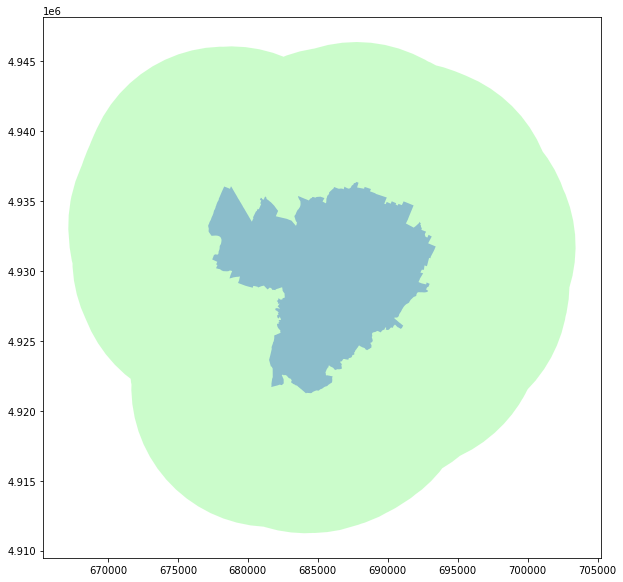

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
bologna_comune.plot(ax=ax, color='blue', alpha=0.5)
buffered_bologna_comune.plot(ax=ax, color='palegreen', alpha=0.5)
plt.show()

### Clip the geotiff

#### Modify CRS

In [20]:
# Path to the folder containing your GeoTIFF files
input_folder = "path input folder"

# Output folder for the reprojected GeoTIFFs
output_folder = "path output folder"


In [21]:
# List all GeoTIFF files in the input folder
geotiff_files = [file for file in os.listdir(input_folder) if file.endswith(".tif")]

In [22]:
# Loop through each GeoTIFF file
for geotiff_file in geotiff_files:
    input_geotiff_path = os.path.join(input_folder, geotiff_file)
    output_geotiff_path = os.path.join(output_folder, geotiff_file)
    
    try:
        # Open the original GeoTIFF
        with rasterio.open(input_geotiff_path) as src:
            transform, width, height = calculate_default_transform(
                src.crs, 'EPSG:32632', src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': 'EPSG:32632',
                'transform': transform,
                'width': width,
                'height': height
            })

            # Reproject and save as a new GeoTIFF with EPSG:32632
            with rasterio.open(output_geotiff_path, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs='EPSG:32632',
                        resampling=Resampling.nearest)
        print(f"Reprojected GeoTIFF: {geotiff_file}")
    except Exception as e:
        print(f"Error processing GeoTIFF: {geotiff_file}, Error: {e}")


Reprojected GeoTIFF: C_ECOSTRESS_L2_LSTE_25469_015_20230102T054318_0601_02_LST_UTM.tif
Reprojected GeoTIFF: C_ECOSTRESS_L2_LSTE_25603_002_20230110T205022_0601_01_LST_UTM.tif
Reprojected GeoTIFF: C_ECOSTRESS_L2_LSTE_25832_007_20230125T151028_0601_01_LST_UTM.tif
Reprojected GeoTIFF: C_ECOSTRESS_L2_LSTE_25878_005_20230128T142100_0601_02_LST_UTM.tif
Reprojected GeoTIFF: C_ECOSTRESS_L2_LSTE_25954_004_20230202T115433_0601_02_LST_UTM.tif
Reprojected GeoTIFF: C_ECOSTRESS_L2_LSTE_26000_002_20230205T110625_0601_02_LST_UTM.tif
Reprojected GeoTIFF: C_ECOSTRESS_L2_LSTE_26122_007_20230213T075443_0601_02_LST_UTM.tif
Reprojected GeoTIFF: C_ECOSTRESS_L2_LSTE_26183_005_20230217T061753_0601_02_LST_UTM.tif
Reprojected GeoTIFF: C_ECOSTRESS_L2_LSTE_26186_008_20230217T110947_0601_02_LST_UTM.tif
Reprojected GeoTIFF: C_ECOSTRESS_L2_LSTE_26354_015_20230228T071246_0601_02_LST_UTM.tif
Reprojected GeoTIFF: C_ECOSTRESS_L2_LSTE_26718_005_20230323T165457_0601_02_LST_UTM.tif
Reprojected GeoTIFF: C_ECOSTRESS_L2_LSTE_26

In [18]:
# check the crs of each geotiff file
for geotiff_file in geotiff_files:
    input_geotiff_path = os.path.join(output_folder, geotiff_file)
    
    with rasterio.open(input_geotiff_path) as src:
        crs = src.crs
        print(f"GeoTIFF: {geotiff_file}, CRS: {crs}")

GeoTIFF: C_ECOSTRESS_L2_LSTE_08454_001_20200102T020941_0601_01_LST_UTM.tif, CRS: EPSG:32632
GeoTIFF: C_ECOSTRESS_L2_LSTE_08500_005_20200105T012223_0601_01_LST_UTM.tif, CRS: EPSG:32632
GeoTIFF: C_ECOSTRESS_L2_LSTE_08515_009_20200106T003501_0601_01_LST_UTM.tif, CRS: EPSG:32632
GeoTIFF: C_ECOSTRESS_L2_LSTE_08622_005_20200112T221225_0601_01_LST_UTM.tif, CRS: EPSG:32632
GeoTIFF: C_ECOSTRESS_L2_LSTE_08683_003_20200116T203733_0601_01_LST_UTM.tif, CRS: EPSG:32632
GeoTIFF: C_ECOSTRESS_L2_LSTE_08881_002_20200129T150655_0601_01_LST_UTM.tif, CRS: EPSG:32632
GeoTIFF: C_ECOSTRESS_L2_LSTE_08988_003_20200205T124732_0601_01_LST_UTM.tif, CRS: EPSG:32632
GeoTIFF: C_ECOSTRESS_L2_LSTE_09003_002_20200206T120002_0601_01_LST_UTM.tif, CRS: EPSG:32632
GeoTIFF: C_ECOSTRESS_L2_LSTE_09232_002_20200221T063327_0601_01_LST_UTM.tif, CRS: EPSG:32632
GeoTIFF: C_ECOSTRESS_L2_LSTE_09598_003_20200315T211004_0601_01_LST_UTM.tif, CRS: EPSG:32632
GeoTIFF: C_ECOSTRESS_L2_LSTE_09720_004_20200323T180403_0601_01_LST_UTM.tif, CRS:

#### Clip

In [23]:
# Path to the directory containing your GeoTIFF files EPSG 32632
input_folder_32632 = "path input folder"
# Output folder for the clipped GeoTIFFs
output_folder_32632 = "path output folder"

In [24]:
# Load the buffered geometry
buffered_geometry = buffered_bologna_comune.to_crs(epsg=32632)
buffered_geometry_geojson = mapping(buffered_geometry.geometry.iloc[0])

In [25]:
# List all GeoTIFF files in the input folder
geotiff_files_32632 = [file for file in os.listdir(input_folder_32632) if file.endswith(".tif")]

In [26]:
# Loop through each GeoTIFF file and perform the clip
for geotiff_file in tqdm(geotiff_files_32632, desc="Clipping GeoTIFFs"):
    input_geotiff_path = os.path.join(input_folder_32632, geotiff_file)
    output_geotiff_file = "B_" + geotiff_file  # Add "B_" prefix to the output filename
    output_geotiff_path = os.path.join(output_folder_32632, output_geotiff_file)
    
    with rasterio.open(input_geotiff_path) as src:
        # Clip the GeoTIFF with the buffered geometry
        clipped, transform = mask(src, [buffered_geometry_geojson], crop=True)
        
        # Update metadata
        meta = src.meta.copy()
        meta.update({
            "height": clipped.shape[1],
            "width": clipped.shape[2],
            "transform": transform,
            "crs": "EPSG:32632"  # Set CRS to EPSG:32632
        })
        
        # Save the clipped GeoTIFF
        with rasterio.open(output_geotiff_path, "w", **meta) as dst:
            dst.write(clipped)

Clipping GeoTIFFs: 100%|██████████| 49/49 [00:18<00:00,  2.67it/s]
